In [46]:
import os
from datasets import load_dataset
from PIL import Image
import pandas as pd
import torch

In [26]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [27]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None) # Show full content of each column (no truncation)
pd.set_option('display.width', None)

In [28]:
dataset = load_dataset("ahmedheakl/arocrbench_khatt",split="train")

In [29]:
results = []
for sample in dataset:
    image = sample["image"]  # Already a PIL Image object
    if image.mode != "RGB":
        image = image.convert("RGB")
    ground_truth = sample["text"]
    results.append({
        "image": image,
        "ground_truth": ground_truth,
        "qari": None,
        
    })
print(f"Initialized results with {len(results)} samples.")

Initialized results with 200 samples.


## Qari-OCr  

In [30]:
from transformers import AutoProcessor, AutoModelForImageTextToText

processor = AutoProcessor.from_pretrained("NAMAA-Space/Qari-OCR-0.1-VL-2B-Instruct",use_fast=True)

model = AutoModelForImageTextToText.from_pretrained("NAMAA-Space/Qari-OCR-0.1-VL-2B-Instruct",torch_dtype="auto",device_map="cuda:0")

In [31]:
from PIL import Image 
import requests

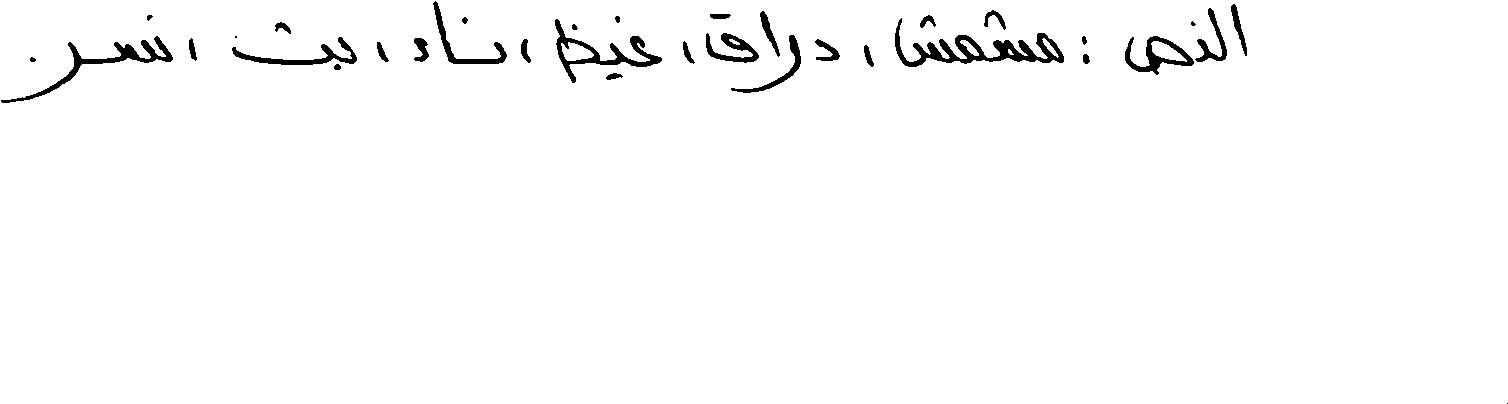

In [32]:
image = dataset[2]['image']
image

In [33]:
dataset[2]['text']

'النص: مشمش ، دراق ، غيظ ، ناء ،  بث ، نسر .'

In [34]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {
                "type": "text",
                "text": "Below is the image of one page of a document, as well as some raw textual content that was previously extracted for it. Just return the plain text representation of this document as if you were reading it naturally. Do not hallucinate"
            }
        ]
    }
]

text_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)



In [35]:
def qwen_extract_ocr(text_prompt,image):
    
    inputs = processor(
        text = [text_prompt],
        images = [image],
        padding = True,
        return_tensors = "pt"
    )

    inputs = inputs.to("cuda:0")

    output_ids = model.generate(**inputs, max_new_tokens=1024)

    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(inputs.input_ids, output_ids)
    ]

    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    return output_text


In [38]:

for i, sample in enumerate(results):
    torch.cuda.empty_cache()
    image = sample['image'].resize((512,512))
    text_result = " ".join(qwen_extract_ocr(text_prompt,image=image)).replace("The Arabic text in the image is:\n\n","")
    print(text_result)
    print("*****"*40)
    results[i]['qari'] = text_result

وصفنا بملح لحادث تخلل ليما2008ه سُرَّا ، ذ مومي مد الله، لتسازان المورن
********************************************************************************************************************************************************************************************************
د هــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــ

In [47]:
import re

def remove_diacritics(text):
    diacritics = [
        '\u0617', '\u0618', '\u0619', '\u061A',  # Small high signs
        '\u064B', '\u064C', '\u064D', '\u064E', '\u064F', '\u0650',  # Tanween and basic diacritics
        '\u0651', '\u0652', '\u0653', '\u0654', '\u0655', '\u0656',  # Shadda, sukun, etc.
        '\u0657', '\u0658', '\u0659', '\u065A', '\u065B', '\u065C', 
        '\u065D', '\u065E', '\u065F', '\u0670'   # Additional Arabic diacritics
    ]
    pattern = '[' + ''.join(diacritics) + ']'
    return re.sub(pattern, '', text)
def remove_english_letters(text):
    # Regex pattern to match English letters (a-z and A-Z)
    pattern = r'[a-zA-Z]'
    # Replace English letters with an empty string
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

In [48]:
def clean_text(text):
    # Replace all tabs and multiple newlines with a single space
    cleaned = re.sub(r'[\n\t]+', ' ', text)
    # Replace multiple spaces with a single space
    cleaned = re.sub(r'\s+', ' ', cleaned)
    # Strip leading/trailing whitespace
    cleaned = cleaned.strip()
    return cleaned

In [58]:
df = pd.read_csv("khattat_dl_namma_result.csv",index_col="Unnamed: 0")

In [59]:
# df = pd.DataFrame(results)
df.head()

,image,ground_truth,qari
0,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2142x141 at 0x74188C56B3D0>,وصفاً مجملاً لحالة المغرب خلال سنة 2005، مثيراً ، في سياق ذلك ، التساؤلات الكبرى,وصفنا بملح لحادث تخلل ليما2008ه سُرَّا ، ذ مومي مد الله، لتسازان المورن
1,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2159x228 at 0x74188C574B10>,وهلال خازن عفيف للحج . بدأت قوافل الحجيج حاج إثر آخر يلبي,د هــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــ
2,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1508x404 at 0x74188C581F90>,النص: مشمش ، دراق ، غيظ ، ناء ، بث ، نسر .,الدم : مسَفَّا، دراق، فِيْم، ناَه، بِث اَسَر.
3,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1236x103 at 0x74188C582C50>,و هي التي جعلته كريما على فقره .,و هي الارْ حبِلَةَ دربماَلى مفْرَهِ.
4,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1873x110 at 0x74188C589F50>,مثل أنقض بغـلس له الضابط لزمتك. سألت راجح هل أبلغ أصحابنا,صل ١٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠٠


In [63]:
df['qari'] = df['qari'].astype(str)

In [64]:
df['ground_truth'] = df['ground_truth'].apply(remove_english_letters).apply(clean_text)
df['qari'] = df['qari'].apply(remove_english_letters).apply(clean_text)

In [65]:

df['ground_truth_t'] = df["ground_truth"].apply(remove_diacritics)
df['qari_t'] = df["qari"].apply(remove_diacritics)

In [66]:
from jiwer import wer, cer 

# for model in ["tesseract","easyocr"]:
for model in ["qari"]:
    wer_score = wer(df["ground_truth"].tolist(), df[model].tolist())
    cer_score = cer(df["ground_truth"].tolist(), df[model].tolist())
    print(f"{model} - WER: {wer_score:.2f}, CER: {cer_score:.2f}")

qari - WER: 3.91, CER: 6.02


In [67]:
df.to_csv("khattat_dl_namma_result.csv")

: 